# <center>Clustering Analysis<center>

<p>Team Name: Data Dredgers
<p>Student Names:

## Instructions
Use generic coding style unless hard-coded values are really necessary.<br>
Your code must be efficient and use self-explanatory naming.<br>
Use appropriate Python library methods for each task instead of using loops.<br>
Run your entire code and save. Then submit this <b>saved</b> copy.

In [2]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

c:\Users\chris\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Data

# WIP - Christian

### Explanation of Columns:

`name` (`str`): Game name for parsing HowLongToBeat
- This is Steam's name for the game, and was used to compare Steam's database to HowLongToBeat's database.

`howlongtobeat` (`str`): Most similar game name found in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`time_to_finish_h` (`str`): Time to finish a run
- How long, in hours, it takes to complete a single run.

`time_to_complete_h` (`str`): Time to complete 100% achievements
- How long, in hours, it takes to complete the game with 100% achievements.

`similarity` (`str`): Similarity relation between games name and the closest game in HowLongToBeat database
- This was used when comparing Steam's database to HowLongToBeat's database.

`perfect_match` (`str`): Values above 0.85 are considered perfect
- This was used when comparing Steam's database to HowLongToBeat's database.

`name_steam_games_database` (`str`): Game as found in column 1
- This is Steam's name for the game.

`appid_steam_games` (`?`): AppID from Steam Games page
- Steam's AppID.

`appid_steam` (`str`): AppID from Steam database (may differ from previous)
- Steam's... AppID?

`name_steam_database` (`str`): Games name as it is found in Steam database
- Steam's... name for the game?

`genre` (`str`): Games genre


<br>
<br>
---

### Columns we are using:
- `time_to_finish_h`
- `time_to_complete_h`
- `genre`
- `positive_votes`
- `negative_votes`
- `tags`
- `finished`
- `played_time`
- `removed_game`
- `positive_rating`
- `total_votes`
- `achievements`

In [ ]:
# Download latest version
path = kagglehub.dataset_download("marcosparrasmolt/steam-library-metadata")
print("Path to dataset files:", path)
dataset_path = os.path.join(path, "Steam_Metadata_Full_marko_pakete.csv")
df = pd.read_csv(dataset_path)

df

Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\marcosparrasmolt\steam-library-metadata\versions\4


,name,howlongtobeat,time_to_finish_h,time_to_complete_h,similarity,perfect_match,name_steam_games_database,appid_steam_games,appid_steam,name_steam_database,...,tags,finished,played_time,release,minimun_requirements,recommended_requirements,removed_game,positive_rating,total_votes,achievements
0,Grand Theft Auto V,Grand Theft Auto V,32,81,1.00,Exact,Grand Theft Auto V,271590,362003.0,Grand Theft Auto V,...,"Open World, Action, Multiplayer, Crime, Automo...",NaN,139.0,13-Apr-2015,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,NaN,85.6,1508816,X
1,Monster Hunter Stories 2: Wings of Ruin,Monster Hunter Stories 2: Wings of Ruin,40,143,1.00,Exact,Monster Hunter Stories 2: Wings of Ruin,1277400,1277400.0,Monster Hunter Stories 2: Wings of Ruin,...,"RPG, Adventure, JRPG, Exploration, 3D, Cartoon...",X,137.0,08-Jul-2021,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,NaN,82.2,13970,X
2,ELDEN RING,Elden Ring,55,133,1.00,Exact,ELDEN RING,1245620,1245620.0,ELDEN RING,...,"Souls-like, Dark Fantasy, RPG, Open World, Dif...",X,122.0,24-Feb-2022,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,NaN,91.6,637890,X
3,Monster Hunter: World,Monster Hunter: World,48,396,1.00,Exact,Monster Hunter: World,582010,582010.0,Monster Hunter: World,...,"Co-op, Multiplayer, Action, Open World, RPG, T...",NaN,110.0,09-Aug-2018,Requires a 64-bit processor and operating syst...,Requires a 64-bit processor and operating syst...,NaN,86.0,373998,X
4,PAYDAY 2,Payday 2,25,465,1.00,Exact,PAYDAY 2,218620,218620.0,PAYDAY 2,...,"Co-op, Action, FPS, Heist, Looter Shooter, Mul...",NaN,96.0,13-Aug-2013,OS: Windows 7Processor: 2 GHz Intel Dual Core ...,OS: Windows 10Processor: 2.3 GHz Intel Quad Co...,NaN,89.6,611958,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,Idle,NaN,NaN,NaN,NaN,NaN,海贼王街机Idle,1962140,NaN,海贼王街机Idle,...,NaN,NaN,0.0,NaN,NaN,NaN,X,NaN,0,NaN
3169,Project Zero,Narcissu Zero,0,3,0.46,Non Exact,瘟疫清零计划 Project Zero,2088250,2088250.0,瘟疫清零计划 Project Zero,...,NaN,NaN,0.0,11-Sep-2022,OS: Window7\/8\/10Processor: Any typeGraphics:...,NaN,NaN,NaN,0,NaN
3170,() \/ Fall...in Love (Demo),reIterate(),2,4,0.18,Non Exact,秋色的記憶(體驗版) / Fall...in Love (Demo),890070,890070.0,秋色的記憶(體驗版) / Fall...in Love (Demo),...,"Free to Play, Adventure, Visual Novel, Otome, ...",NaN,0.0,26-Jul-2018,OS: Windows 7+Processor: Intel AtomMemory: 1 G...,NaN,NaN,92.7,151,NaN
3171,NaN,NaN,NaN,NaN,NaN,NaN,秦殇,970500,970500.0,秦殇 (Prince of Qin),...,"Action, RPG, Adventure, Action RPG, Party-Base...",NaN,0.0,10-Jan-2022,"OS: Windows7,windows10Processor: Intel Pentium...",OS:,NaN,76.8,1954,NaN


## Visual Exploration of Data

### Testing Stuff
This is just stuff I'm using to test with. - Christian

<Axes: >

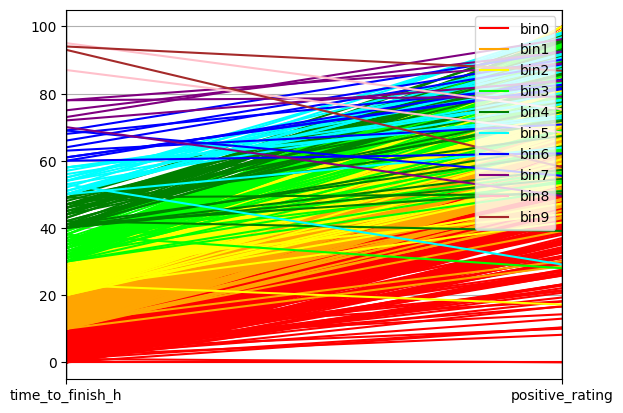

In [384]:
def binify(df, bins, col_to_bin, min, max):
    rng = max-min
    rngBin = rng/bins

    for i, row in df.iterrows():
        if row[col_to_bin] == df[col_to_bin].max():
            df.at[i, 'bin'] = "bin"+(str)((int)(row[col_to_bin]//rngBin - 1))
        else:
            df.at[i, 'bin'] = "bin"+(str)((int)(row[col_to_bin]//rngBin))
    return df

# Python doesn't support overloading...
# def binify(df, bins, col_to_bin):
#     binify(df, bins, col_to_bin, df[col_to_bin].min(), df[col_to_bin].max())

def restrict(df, col_to_restrict, min, max):
    df = df[df[col_to_restrict] >= min]
    df = df[df[col_to_restrict] <= max]
    return df


# Only grab the time to finish (in hrs) and positive rating (0-100) columns
ttfh = df.filter(items=["time_to_finish_h", "positive_rating"])
# Remove bad entries (not registered or NaN)
ttfh = ttfh[ttfh["time_to_finish_h"] != "No time registered yet"]
ttfh = ttfh.dropna(ignore_index=True)
# Convert time_to_finish from string to int
ttfh["time_to_finish_h"] = ttfh["time_to_finish_h"].apply(lambda x: int(x))
# Remove outliers
min = 0
max = 100


ttfh = restrict(ttfh, "time_to_finish_h", min,max)
# Normalize data (min-max recommended)
# ttfh = (ttfh-ttfh.mean())/ttfh.std() # mean normalization
# ttfh=(ttfh-ttfh.min())/(ttfh.max()-ttfh.min()) # min-max normalization
# Bin data so we can better visualize the data
ttfh = binify(ttfh, 10, "time_to_finish_h", min, max)

ttfh

# Histogram
# test = ttfh.hist(bins=10)
# plt.tight_layout()

# Plot as parallel coordinate plot
ttfh = ttfh.sort_values(by=["bin"]) # Sorts values so the bins show in color order
pd.plotting.parallel_coordinates(ttfh, "bin", color=('red', 'orange', 'yellow', 'lime', 'green', 'cyan', 'blue', 'purple', 'pink', 'brown'))

### Histograms

array([1.39e+02, 1.37e+02, 1.22e+02, 1.10e+02, 9.60e+01, 5.10e+01,
       5.00e+01, 4.30e+01, 4.00e+01, 3.90e+01, 3.50e+01, 3.40e+01,
       3.30e+01, 3.20e+01, 3.00e+01, 2.80e+01, 2.70e+01, 2.60e+01,
       2.50e+01, 2.30e+01, 2.20e+01, 2.10e+01, 1.99e+01, 1.93e+01,
       1.85e+01, 1.83e+01, 1.73e+01, 1.72e+01, 1.67e+01, 1.66e+01,
       1.65e+01, 1.64e+01, 1.63e+01, 1.62e+01, 1.60e+01, 1.55e+01,
       1.54e+01, 1.53e+01, 1.52e+01, 1.51e+01, 1.50e+01, 1.49e+01,
       1.48e+01, 1.47e+01, 1.46e+01, 1.45e+01, 1.44e+01, 1.41e+01,
       1.39e+01, 1.37e+01, 1.36e+01, 1.29e+01, 1.27e+01, 1.26e+01,
       1.25e+01, 1.22e+01, 1.16e+01, 1.14e+01, 1.13e+01, 1.12e+01,
       1.11e+01, 1.08e+01, 1.05e+01, 1.03e+01, 1.02e+01, 1.01e+01,
       1.00e+01, 9.90e+00, 9.80e+00, 9.60e+00, 9.50e+00, 9.40e+00,
       9.30e+00, 9.20e+00, 9.10e+00, 9.00e+00, 8.90e+00, 8.80e+00,
       8.70e+00, 8.60e+00, 8.50e+00, 8.30e+00, 8.20e+00, 8.10e+00,
       8.00e+00, 7.90e+00, 7.80e+00, 7.70e+00, 7.60e+00, 7.50e

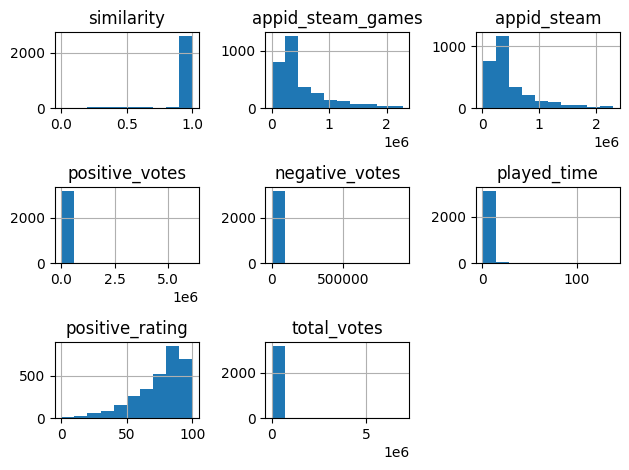

In [ ]:
hist = df.hist(bins = 10 )
plt.tight_layout()

### Distributions

### Box-Whisker Plots

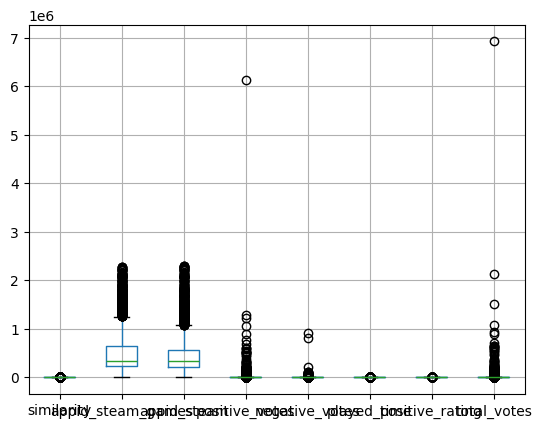

In [4]:
boxplot = df.boxplot()


### Violin Plots

## Data Quality & Cleaning

Instruction: Add a comment for each method

## Handling Redundancy

### X-square Test

### Correlation Analysis

### Visual Exploration (scatter-plot matrix)

## Dimensionality Reduction

### PCA

## Discretization

### Histogram of Discretized Attribute

### X-square Test of Discretized Attributes

### Visual Exploration (scatter-plot matrix) of Discretized Attributes

## Feature Selection/Generation

### Select Features

### Generate Features

# Generate Clusters

## K-means

## Hierarchical

# Evaluation of Clusters

See instructions provided in the report template

## <center> REFERENCES </center>
List resources (book, internet page, etc.) that you used to complete this challenge.

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html
